### Import dependencies

In [76]:
import cv2
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import random
from sklearn.metrics import classification_report, confusion_matrix
import glob
import seaborn as sns
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import Counter
import pandas as pd
from PIL import Image

In [77]:
from PIL import Image

from PIL import Image, ImageEnhance
import torchvision.transforms as transforms
import random
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch

def augment_image(image):
    transform_list = [
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomResizedCrop(250, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ]
    transform = transforms.Compose(transform_list)
    return transform(image)

def preprocess_lung_image(image):
    img = np.array(image.convert('L'))  # Convert to grayscale and then to numpy array
    
    # Adaptive histogram equalization with a smaller grid
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(5, 5))
    equalized = clahe.apply(img)
    
    # Find the contour of the chest cavity
    _, binary = cv2.threshold(equalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (assumed to be the chest cavity)
    if contours:
        main_contour = max(contours, key=cv2.contourArea)
    else:
        print("No contours found in the image.")
        return img, equalized, None, None, None
    
    # Create a mask with the contour
    mask = np.zeros_like(equalized)
    cv2.drawContours(mask, [main_contour], -1, (255), thickness=cv2.FILLED)
    
    # Apply the mask to the equalized image
    masked_image = cv2.bitwise_and(equalized, equalized, mask=mask)
    
    # Create a color image with three channels (RGB) to draw the contour in red
    contour_image = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2BGR)
    
    # Draw the contour in red (RGB: 255, 0, 0)
    for point in main_contour:
        contour_image[point[0][1], point[0][0]] = [255, 0, 0]
    
    # Get the bounding rectangle
    x, y, w, h = cv2.boundingRect(main_contour)
    
    # Crop the image
    cropped = masked_image[y:y+h, x:x+w]
    
    # Make the image square
    size = max(w, h)
    square = np.zeros((size, size), dtype=np.uint8)
    
    # Center the cropped image in the square
    start_x = (size - w) // 2
    start_y = (size - h) // 2
    square[start_y:start_y+h, start_x:start_x+w] = cropped
    
    # Resize to 250x250
    resized = cv2.resize(square, (250, 250))
    
    return img, equalized, binary, mask, cropped, square, resized

class LungCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment=False):
        self.root_dir = root_dir
        self.transform = transform
        self.augment = augment
        self.labels = {"adenocarcinoma": 0, "large.cell.carcinoma": 1, "normal": 2, "squamous.cell.carcinoma": 3}
        self.filepaths = []
        self.targets = []
        
        for label in self.labels.keys():
            paths = glob.glob(f"{root_dir}/{label}/*.png")
            self.filepaths.extend(paths)
            self.targets.extend([self.labels[label]] * len(paths))
    
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, index):
        image_path = self.filepaths[index]
        with Image.open(image_path) as img:
            if self.augment:
                img = augment_image(img)
            img, equalized, binary, mask, cropped, square, resized = preprocess_lung_image(img)
            img = Image.fromarray(np.stack((resized, resized, resized), axis=-1))  # Create a 3-channel image
        
            if self.transform:
                img = self.transform(img)
        
        label = self.targets[index]
        return img, label
    
    def show_images(self, num_images=6, rows=2):
        cols = num_images // rows
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
        indices = random.sample(range(len(self)), num_images)
        
        for ax, index in zip(axes.flatten(), indices):
            img_path = self.filepaths[index]
            with Image.open(img_path) as img:
                img, equalized, binary, mask, cropped, square, resized = preprocess_lung_image(img)
                label = self.targets[index]
                label_name = list(self.labels.keys())[list(self.labels.values()).index(label)]
                ax.imshow(resized, cmap='gray')
                ax.axis('off')
                ax.set_title(label_name)
        
        plt.tight_layout()
        plt.show()

# Define transforms (if any)
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


In [78]:
# Create dataset instances
train_dataset = LungCancerDataset(root_dir='./data/train', transform=data_transforms)
valid_dataset = LungCancerDataset(root_dir='./data/valid', transform=data_transforms)

# Use DataLoader to create batches
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

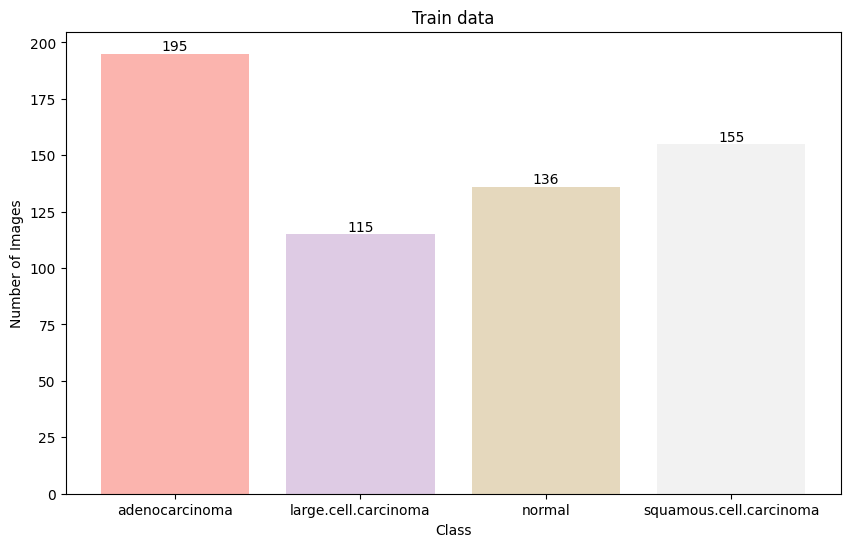

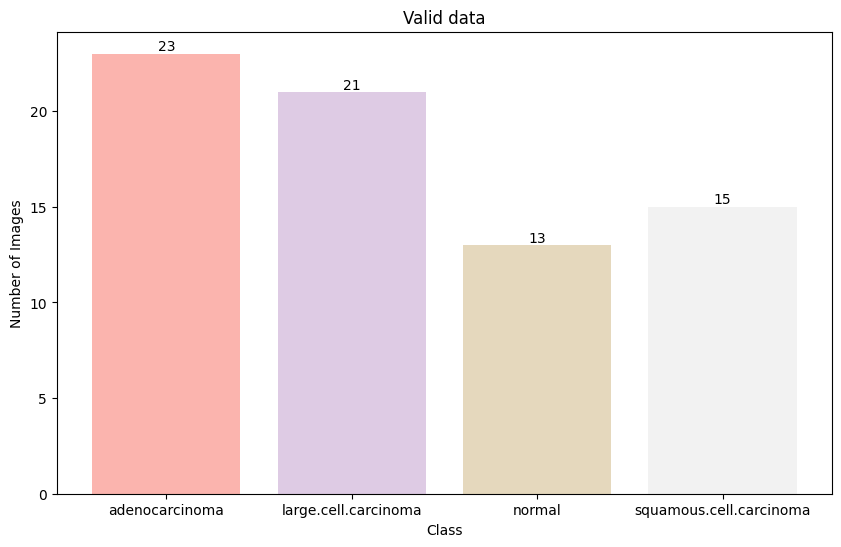

In [79]:
def plot_nimages(dataset, count, name):
    class_names = list(dataset.labels.keys())
    counts = [count[dataset.labels[class_name]] for class_name in class_names]

    colors = plt.cm.Pastel1(np.linspace(0, 1, len(class_names)))

    plt.figure(figsize=(10, 6))
    for i, class_name in enumerate(class_names):
        plt.bar(class_name, counts[i], color=colors[i])

    plt.title(name)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')

    for index, value in enumerate(counts):
        plt.text(index, value, str(value), ha='center', va='bottom')

    plt.show()
    
# Count the number of images per class
train_count = Counter(train_dataset.targets)
valid_count = Counter(valid_dataset.targets)
    
# Plot the number of images per class
plot_nimages(train_dataset, train_count, name='Train data')
plot_nimages(valid_dataset, valid_count, name='Valid data')

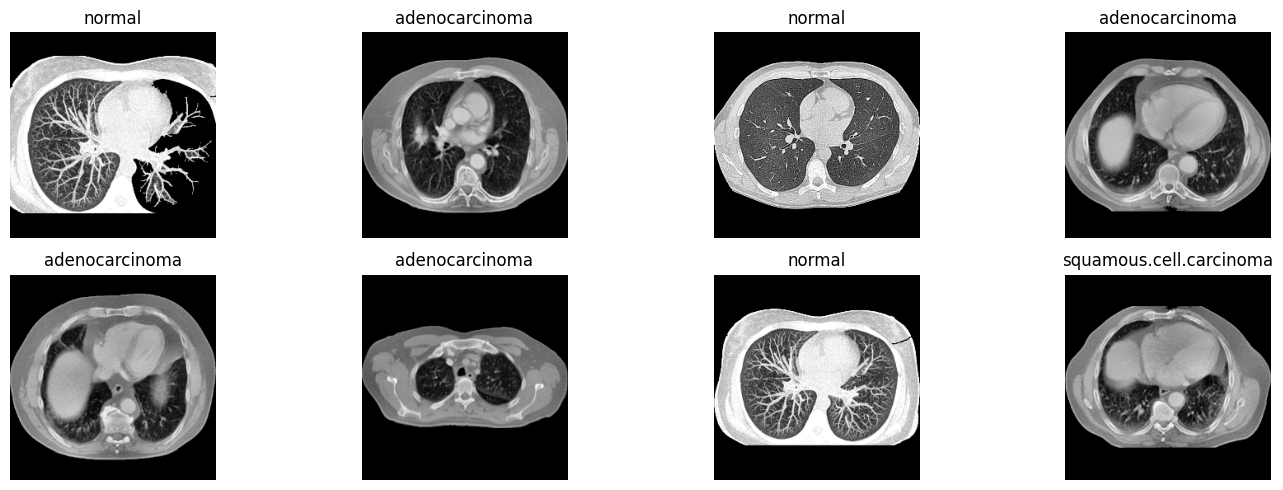

In [80]:
train_dataset.show_images(num_images=8, rows=2)

In [81]:
class ModifiedResNet50(nn.Module):
    def __init__(self, num_classes=4):
        super(ModifiedResNet50, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(num_ftrs, num_classes)
        )
        self.batch_norm = nn.BatchNorm1d(num_ftrs)

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.batch_norm(x)
        x = self.model.fc(x)
        return x

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedResNet50().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

def train_model(dataloader, model, criterion, optimizer, num_epochs):
    train_loss_history = []
    valid_loss_history = []
    valid_acc_history = []
    
    best_model_wts = None
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        
        for i, (inputs, labels) in enumerate(dataloader['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(dataloader['train'].dataset)
        train_loss_history.append(epoch_loss)
        
        val_loss, val_acc = validate_model(dataloader['valid'], model, device, criterion)
        valid_loss_history.append(val_loss)
        valid_acc_history.append(val_acc)
        
        print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')
        scheduler.step(val_loss)
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict().copy()
    
    print(f'Best Validation Accuracy: {best_acc}')
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'best_model.pth')
    
    return train_loss_history, valid_loss_history, valid_acc_history

/home/drtey/dev/chest-CT-Scan/ctscan/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/drtey/dev/chest-CT-Scan/ctscan/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/drtey/dev/chest-CT-Scan/ctscan/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [83]:
def validate_model(dataloader, model, device, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    loss = running_loss / len(dataloader.dataset)
    accuracy = correct / total
    
    return loss, accuracy

In [84]:
def plot_metrics(train_loss, valid_loss, valid_acc):
    epochs = range(len(train_loss))
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, valid_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0.0, 1.0)
    plt.legend()
    plt.title('Loss over Epochs')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, valid_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0.0, 1.0)
    plt.legend()
    plt.title('Accuracy over Epochs')
    
    plt.tight_layout()
    plt.show()

dataloader = {'train': train_dataloader, 'valid': valid_dataloader}

num_epochs = 32
train_loss, valid_loss, valid_acc = train_model(dataloader, model, criterion, optimizer, num_epochs)

plot_metrics(train_loss, valid_loss, valid_acc)

test_dataset = LungCancerDataset(root_dir='./data/test', transform=data_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def test_model(test_dataloader, model, device):
    model.eval()
    correct = 0
    total = 0
    test_predictions = []
    test_labels = []
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_predictions.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    accuracy = correct / total
    print(f'Accuracy of the model on the test images: {100 * accuracy}%')
    return test_labels, test_predictions

test_labels, test_predictions = test_model(test_dataloader, model, device)

Epoch 0/31, Train Loss: 0.6194322132032842, Validation Loss: 0.9589196443557739, Validation Accuracy: 0.5833333333333334
Epoch 1/31, Train Loss: 0.08360150480602625, Validation Loss: 0.7546710305743747, Validation Accuracy: 0.6805555555555556
Epoch 2/31, Train Loss: 0.023062594191553987, Validation Loss: 0.3765711552566952, Validation Accuracy: 0.875
Epoch 3/31, Train Loss: 0.012081398367928264, Validation Loss: 0.4483550186786387, Validation Accuracy: 0.875
Epoch 4/31, Train Loss: 0.015677353554713648, Validation Loss: 0.47543463110923767, Validation Accuracy: 0.8472222222222222
Epoch 5/31, Train Loss: 0.014675535275577606, Validation Loss: 0.5097487270832062, Validation Accuracy: 0.8333333333333334
Epoch 6/31, Train Loss: 0.018245473939510135, Validation Loss: 0.7942073742548624, Validation Accuracy: 0.7916666666666666
Epoch 7/31, Train Loss: 0.05414461916600805, Validation Loss: 0.6612951577537589, Validation Accuracy: 0.8055555555555556
Epoch 8/31, Train Loss: 0.055096705008713456,

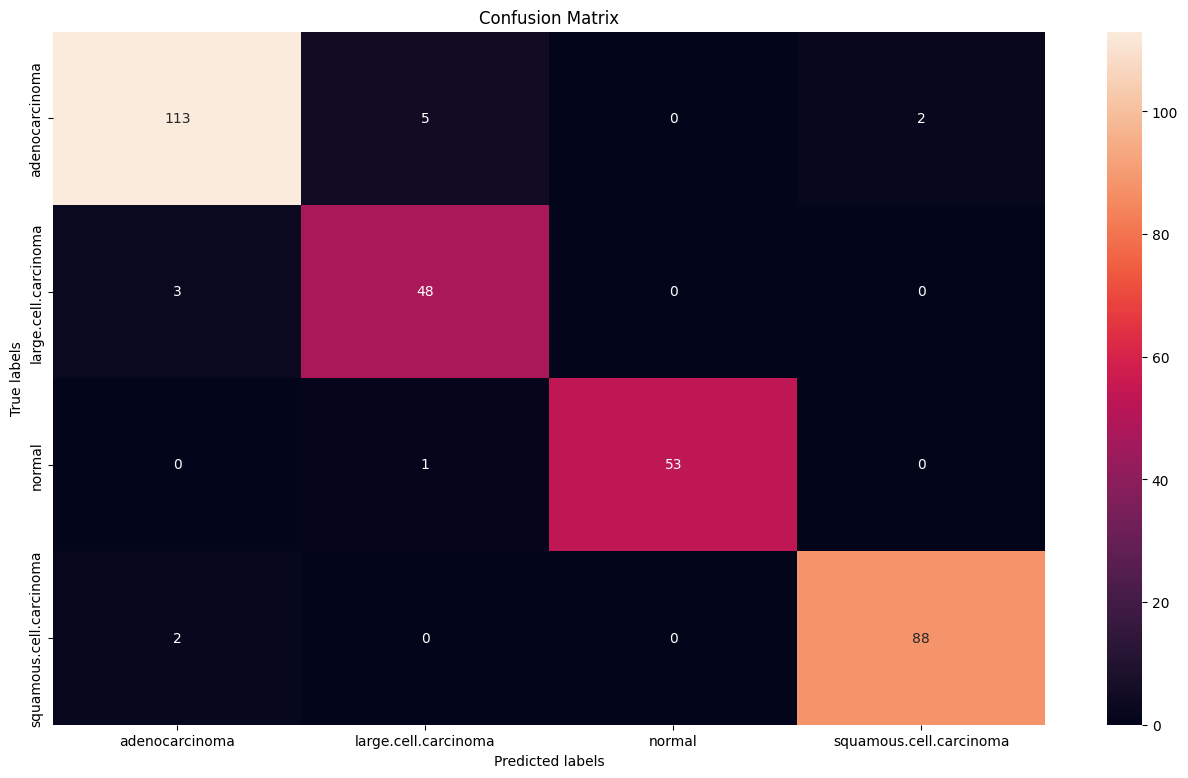

In [ ]:
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(16, 9))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma'])
ax.yaxis.set_ticklabels(['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma'])
plt.show()

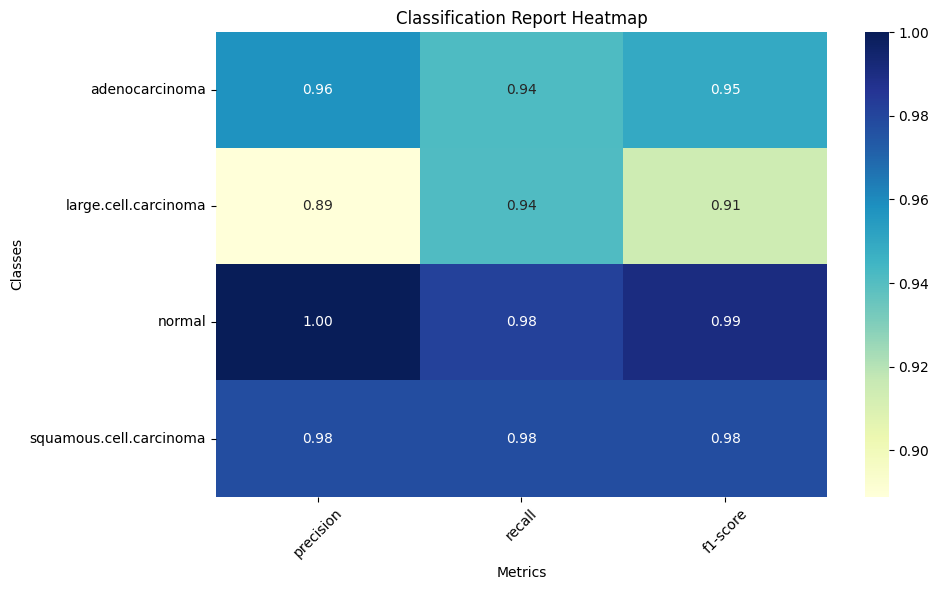

In [ ]:
report = classification_report(test_labels, test_predictions, target_names=['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma'], output_dict=True)

df = pd.DataFrame(report).T
df = df.drop(columns=['support'])  

plt.figure(figsize=(10, 6))
sns.heatmap(df.iloc[:-3, :], annot=True, cmap='YlGnBu', cbar=True, fmt='.2f')

plt.title('Classification Report Heatmap')
plt.ylabel('Classes')
plt.xlabel('Metrics')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()